# Coming from TensorFlow to NengoDL

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/from-tensorflow.ipynb)

NengoDL combines two frameworks: Nengo and TensorFlow.  This tutorial is designed for people who are familiar with TensorFlow and looking to learn more about neuromorphic modelling with NengoDL.  For the other approach, users familiar with Nengo looking to learn how to use NengoDL, check out [this tutorial](https://www.nengo.ai/nengo-dl/examples/from-nengo.html).

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import nengo
from nengo.utils.matplotlib import rasterplot
import numpy as np
import tensorflow as tf

import nengo_dl


warnings.simplefilter("ignore")

## What is Nengo

We'll start with the very basics, where you might be wondering what Nengo is and why you would want to use it.  Nengo is a tool for constructing and simulating neural networks.  That is, to some extent, the same purpose as TensorFlow (and its higher level API, Keras).  For example, here is how we might build a simple two layer auto-encoder network in TensorFlow:

In [2]:
n_in = 784
n_hidden = 64
minibatch_size = 50

# input
tf_a = tf.keras.Input(shape=(n_in,))

# first layer
tf_b = tf.keras.layers.Dense(
    n_hidden, activation=tf.nn.relu,
    kernel_initializer=tf.initializers.glorot_uniform()
)(tf_a)

# second layer
tf_c = tf.keras.layers.Dense(
    n_in, activation=tf.nn.relu,
    kernel_initializer=tf.initializers.glorot_uniform()
)(tf_b)

And here is how we would build the same network architecture in Nengo:

In [3]:
with nengo.Network() as auto_net: 
    # input
    nengo_a = nengo.Node(np.zeros(n_in))
    
    # first layer
    nengo_b = nengo.Ensemble(
        n_hidden, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot())
    
    # second layer
    nengo_c = nengo.Ensemble(
        n_in, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons, 
        transform=nengo_dl.dists.Glorot())
    
    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)

One difference you'll note is that with Nengo we separate the creation of the layers and the creation of the connections between layers.  This is because the connection structure in Nengo networks often has a lot more state and general complexity than in typical deep learning networks, so it is helpful to be able to control it independently (we'll see examples of this later).

Another new object you may notice is the `nengo.Probe`.  This is used to collect data from the simulation; by adding a probe to `nengo_c.neurons`, we are indicating that we want to collect the activities of those neurons when the simulation is running.  You can think of this like the `outputs` arguments in a Keras Model.

We will not go into a lot of detail on Nengo here; there is much more functionality available, but we will focus on the features most familiar or relevant to those coming from a TensorFlow background.  For a more in-depth introduction to Nengo, check out the Nengo-specific [documentation](https://www.nengo.ai/nengo/) and [examples](https://www.nengo.ai/nengo/examples.html).

## Simulating a network

To simulate a Keras network we create a `Model` and call `model.predict`:

In [4]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
model.predict(np.ones((minibatch_size, n_in)));

Again, accomplishing the same thing in Nengo bears many similarities.  We create a `Simulator` and call `sim.predict`:

In [5]:
with nengo_dl.Simulator(network=auto_net, 
                        minibatch_size=minibatch_size) as sim:
    sim.predict(np.ones((minibatch_size, 1, n_in)));

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

| #                       Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|#####         Constructing graph: build stage (9%)              | ETA: 0:00:00

|##############Constructing graph: build stage (63%)             | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

|  #                      Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

One difference you may note is the extra dimension with size 1 in the shape of the Nengo inputs.  This represents the time dimension; in this example we're only running for a single timestep, which is why it has size 1, but this could be used to provide different input values on each simulation timestep.

This highlights a key difference between Nengo and TensorFlow.  Nengo simulations are fundamentally temporal in nature; unlike TensorFlow where the graph simply represents an abstract set of computations, in Nengo we (almost) always think of the graph as representing a stateful neural simulation, where values are accumulated, updated, and communicated over time.  This is not to say there is no overlap (we can create TensorFlow simulations that execute over time, and we can create Nengo simulations without temporal dynamics), but this is a different way of thinking about computations that influences how we construct and simulate networks in Nengo.

More details on the NengoDL Simulator can be found in [the user guide](https://www.nengo.ai/nengo-dl/simulator.html).

## Spiking networks

Although Nengo can be used to create TensorFlow-style networks, it has been primarily designed for a different style of modelling: "neuromorphic" networks.  Neuromorphic networks include features drawn from biological neural networks, in an effort to understand or recreate the functionality of biological brains.  Note that these models fall on a spectrum with standard artificial neural networks, with different approaches incorporating different biological features.  But in general the structure and parameterization of these networks often differs significantly from standard deep network architectures.

We touched on this above in the discussion of temporality, which is one common feature of neuromorphic networks.  Another common characteristic is the use of more complicated neuron models, in particular spiking neurons.  In contrast to "rate" neurons (like `relu`) that output a continuous value, spiking neurons communicate via discrete bursts of output called spikes.

We can visualize this difference with a simple 1-layer network. In this example we'll use `sim.run_steps` to run the simulation, rather than `sim.predict`.  `sim.run_steps` (or `sim.run`) is a standard Nengo Simulator execution function (as opposed to `sim.predict`, which is specific to NengoDL).  We could use either one, but you will probably see `sim.run` in Nengo code, so we introduce it here.  The main difference in this case is that results will be stored in the `sim.data` dictionary, as opposed to being returned directly from `sim.predict`.

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|####          Constructing graph: build stage (7%)              | ETA: 0:00:00

|##############Constructing graph: build stage (92%)########     | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|  #                      Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

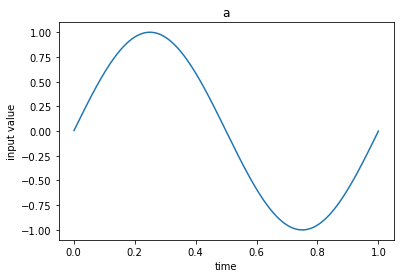

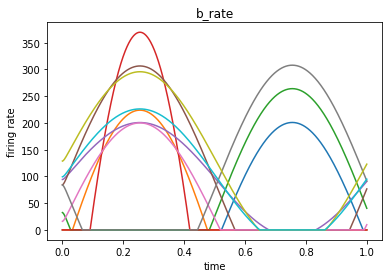

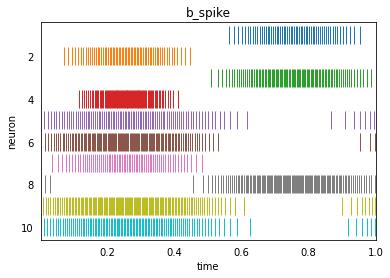

In [6]:
with nengo.Network() as net:
    # our input node will output a sine wave with a period of 1 second
    a = nengo.Node(lambda t: np.sin(2 * np.pi * t))
    
    # we'll create one ensemble with rate neurons
    b_rate = nengo.Ensemble(
        10, 1, neuron_type=nengo.RectifiedLinear(), seed=2)
    nengo.Connection(a, b_rate)
    
    # and another ensemble with spiking neurons
    b_spike = nengo.Ensemble(
        10, 1, neuron_type=nengo.SpikingRectifiedLinear(), seed=2)
    nengo.Connection(a, b_spike)
    
    p_a = nengo.Probe(a)
    p_rate = nengo.Probe(b_rate.neurons)
    p_spike = nengo.Probe(b_spike.neurons)
    
with nengo_dl.Simulator(net) as sim:
    # simulate the model for 1 second
    # note that we are not providing any input data, so input 
    # data will be automatically generated based on the sine function
    # in the Node definition.
    sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[p_a])
plt.xlabel("time")
plt.ylabel("input value")
plt.title("a")
    
plt.figure()
plt.plot(sim.trange(), sim.data[p_rate])
plt.xlabel("time")
plt.ylabel("firing rate")
plt.title("b_rate")

plt.figure()
rasterplot(sim.trange(), sim.data[p_spike])
plt.xlabel("time")
plt.ylabel("neuron")
plt.title("b_spike");

Each neuron responds to the input signal differently due to the random parameterization in the network (e.g. connection weights and biases).  We have matched the parameterization in the rate and spiking ensembles so that it is easier to see the parallels.

Note that the same information is being represented in the two ensembles.  For example, when the second neuron (orange) is outputting a high continuous value (in the second graph), the corresponding spiking neuron is outputting more discrete spikes (orange lines in the third graph).

We can see the parallels more clearly if we introduce another Nengo feature, synaptic filters.  This is inspired by a biological feature where discrete spikes induce a continuous electrical waveform in the receiving neuron, at the synapse (the point where the two neurons connect).  But computationally we can think of this simply as applying a filter to the spiking signal.

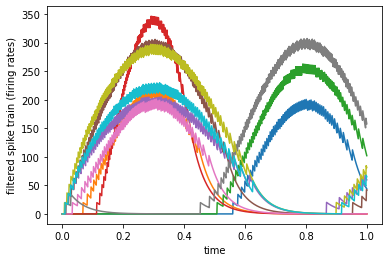

In [7]:
# nengo uses a linear lowpass filter by default
filt = nengo.Lowpass(tau=0.05)

# apply filter to ensemble output spikes
filtered_spikes = filt.filt(sim.data[p_spike])

plt.figure()
plt.plot(sim.trange(), filtered_spikes)
plt.xlabel("time")
plt.ylabel("filtered spike train (firing rates)");

We can see how the spike trains, when viewed through a synaptic filter, approximate the continuous rate values in the second graph above.  

In this example we have computed the filtered signal manually for demonstration purposes, but in a typical Nengo model these synaptic filters are applied throughout the model, on the `Connection` objects.  For example, the above filtering would be equivalent to `nengo.Connection(b_spike.neurons, x, synapse=0.05)` (from the perspective of a hypothetical downstream object `x`).

This is a helpful duality to keep in mind when coming to neuromorphic modelling and Nengo from a standard deep network background.  Although spiking neurons seem like a radically different paradigm, they can compute and communicate the same information as their rate counterparts.  But note that this only makes sense when we think of the network temporally (neurons spiking and being filtered over time).

There are many other neuron types built into Nengo (see [the documentation](https://www.nengo.ai/nengo/frontend-api.html#neuron-types) for a complete list).  These neuron models have various different behaviours, and managing their parameterization and simulation is an important part of Nengo's design.

## Inserting TensorFlow code

The goal of NengoDL is not to replace TensorFlow or Nengo, but to allow them to smoothly work together.  Thus one important feature is the ability to write TensorFlow code directly, and insert it into a Nengo network.  This allows us to use whichever framework is best suited for different parts of a model.

This functionality is accessed through the `nengo_dl.TensorNode` class.  This allows us to wrap TensorFlow code in a Nengo object, so that it can easily communicate with the rest of a Nengo model.  The TensorFlow code is written in a function that takes `tf.Tensors` as input, applies the desired manipulations through TensorFlow operations, and returns a `tf.Tensor`.  We then pass that function to the TensorNode.

For simple cases we can use `nengo_dl.Layer`.  This is a simplified interface for constructing `TensorNodes` that mimics the Keras functional API.  For example, suppose we want to apply batch normalization to the output of one of the Nengo ensembles.  There is no built-in way to do batch normalization in Nengo, so we can instead turn to TensorFlow for this part of the model.

In [8]:
with net:
    batch_norm = nengo_dl.Layer(
        tf.keras.layers.BatchNormalization(momentum=0.9))(b_rate.neurons)
    p_batch_norm = nengo.Probe(batch_norm)

This is essentially equivalent to the Keras layer `tf.keras.layers.BatchNormalization`, except it works with Nengo objects.  For example, `b_rate` is a `nengo.Ensemble` in this case, and we can add Probes or Connections to `batch_norm` in the same way as any other Nengo object.

Using `nengo_dl.Layer` is simply a shortcut for creating a `TensorNode` and `Connection`; the above is equivalent to

In [9]:
with net:
    batch_norm = nengo_dl.TensorNode(
        tf.keras.layers.BatchNormalization(momentum=0.9), 
        shape_in=(10,), pass_time=False)
    nengo.Connection(b_rate.neurons, batch_norm, synapse=None)
    p_batch_norm = nengo.Probe(batch_norm)

In general, we can use any function (a built in TensorFlow function or one we write ourselves) in a TensorNode.  It can accept two parameters, `t` and `x`, where `t` is the current simulation time and `x` is the value of any Connections incoming to the TensorNode.  We can use `pass_time=False` if we don't need the time input. `x` will have shape `(minibatch_size,) + shape_in`, where `shape_in` is the parameter passed to the `TensorNode` (or inferred from the input object in the case of `nengo_dl.Layer`).  The `TensorNode`/`Layer` function should return a `tf.Tensor` with shape `(minibatch_size,) + shape_out`, where `shape_out` is the output dimensionality of the node (dependent on the manipulations applied to the inputs `x`).  We could explicitly specify `shape_out=(10,)` in the above example, or if we don't specify the output shape it will be determined automatically by calling the node function with placeholder inputs.

Here is a simple network to illustrate a TensorNode's input and output:

In [10]:
with nengo.Network() as net:
    # node to provide an input value for the TensorNode
    a = nengo.Node([0.5, -0.1]) 
    
    # a TensorNode function to illustrate i/o
    def tensor_func(t, x):
        # print out the value of inputs t and x
        print_t = tf.print("t:", t)
        with tf.control_dependencies([print_t]):
            print_x = tf.print("x:", x)
        
        # output t + x
        with tf.control_dependencies([print_x]):
            return tf.add(t, x)
        
    # create the TensorNode
    b = nengo_dl.TensorNode(tensor_func, shape_in=(2,), 
                            shape_out=(2,))
    nengo.Connection(a, b, synapse=None)
    
    p = nengo.Probe(b)
    
with nengo_dl.Simulator(net) as sim:
    print("TensorNode input:")
    data = sim.predict(n_steps=10)
    print("TensorNode output:")
    print(data[p])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

| #                       Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

TensorNode input:
t: 0.001


x: [[0.5 -0.1]]


t: 0.002


x: [[0.5 -0.1]]


t: 0.003


x: [[0.5 -0.1]]


t: 0.004


x: [[0.5 -0.1]]


t: 0.00500000035


x: [[0.5 -0.1]]


t: 0.006


x: [[0.5 -0.1]]


t: 0.007


x: [[0.5 -0.1]]


t: 0.008


x: [[0.5 -0.1]]


t: 0.00900000054


x: [[0.5 -0.1]]


t: 0.0100000007


x: [[0.5 -0.1]]


TensorNode output:
[[[ 0.501 -0.099]
  [ 0.502 -0.098]
  [ 0.503 -0.097]
  [ 0.504 -0.096]
  [ 0.505 -0.095]
  [ 0.506 -0.094]
  [ 0.507 -0.093]
  [ 0.508 -0.092]
  [ 0.509 -0.091]
  [ 0.51  -0.09 ]]]


We can see, as we expect, that the input tensor `t` is reflecting the current simulation time over the 10 timesteps we executed, and `x` contains the value of the input Node that we connected to the TensorNode.  And we can see in the probe data that the TensorNode is outputting the operation we defined in TensorFlow (`tf.add(t, x)`).

We can define more complicated TensorNodes by implementing a custom Keras Layer.  This can be useful, for example, if the TensorNode requires internal parameters (which should be created in the Keras Layer's `build` function).

Here is a simple TensorNode that illustrates the usage of a custom Layer:

In [11]:
with nengo.Network() as net:
    class MyLayer(tf.keras.layers.Layer):
        def build(self, input_shapes):
            self.w = self.add_weight(shape=(1, 1))
        
        def call(self, inputs):
            return inputs * self.w
            
    a = nengo_dl.TensorNode(MyLayer(), shape_in=(1,), 
                            pass_time=False)

More details on TensorNode usage can be found in [the user guide](https://www.nengo.ai/nengo-dl/tensor-node.html).

## Deep learning parameter optimization

NengoDL allows model parameters to be optimized via TensorFlow optimization algorithms, through the `Simulator.fit` function.  Returning to the autoencoder examples from the beginning of this tutorial, we'll optimize those networks to encode MNIST digits.

In [12]:
# download MNIST dataset
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()
# flatten images
train_data = train_data.reshape((train_data.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))

n_epochs = 2

In TensorFlow the training would be done something like:

Epoch 1/2


   1/1875 [..............................] - ETA: 0s - loss: 6723.7656

  33/1875 [..............................] - ETA: 2s - loss: 4259.3921

  65/1875 [>.............................] - ETA: 2s - loss: 3604.2271

  97/1875 [>.............................] - ETA: 2s - loss: 3189.1907

 123/1875 [>.............................] - ETA: 2s - loss: 2969.9651

 155/1875 [=>............................] - ETA: 2s - loss: 2757.3848

 184/1875 [=>............................] - ETA: 2s - loss: 2608.3215

 216/1875 [==>...........................] - ETA: 2s - loss: 2472.7224

 248/1875 [==>...........................] - ETA: 2s - loss: 2363.4028

 280/1875 [===>..........................] - ETA: 2s - loss: 2264.6396

 312/1875 [===>..........................] - ETA: 2s - loss: 2180.1182

 344/1875 [====>.........................] - ETA: 2s - loss: 2110.7209

 376/1875 [=====>........................] - ETA: 2s - loss: 2049.4050

 408/1875 [=====>........................] - ETA: 2s - loss: 1993.0759

 435/1875 [=====>........................] - ETA: 2s - loss: 1951.5214

 467/1875 [======>.......................] - ETA: 2s - loss: 1903.0048

 499/1875 [======>.......................] - ETA: 2s - loss: 1860.2864

 529/1875 [=======>......................] - ETA: 2s - loss: 1822.1598

 561/1875 [=======>......................] - ETA: 2s - loss: 1787.4438

 592/1875 [========>.....................] - ETA: 2s - loss: 1755.0667

 623/1875 [========>.....................] - ETA: 2s - loss: 1724.8049

 655/1875 [=========>....................] - ETA: 1s - loss: 1696.2480

 687/1875 [=========>....................] - ETA: 1s - loss: 1668.6155

 719/1875 [==========>...................] - ETA: 1s - loss: 1643.4319

 751/1875 [===========>..................] - ETA: 1s - loss: 1621.0922

 783/1875 [===========>..................] - ETA: 1s - loss: 1598.9952

 815/1875 [============>.................] - ETA: 1s - loss: 1578.1866

 846/1875 [============>.................] - ETA: 1s - loss: 1559.2368

 878/1875 [=============>................] - ETA: 1s - loss: 1540.5616

 910/1875 [=============>................] - ETA: 1s - loss: 1521.4519

 942/1875 [==============>...............] - ETA: 1s - loss: 1505.0378

 974/1875 [==============>...............] - ETA: 1s - loss: 1489.2240

1006/1875 [===============>..............] - ETA: 1s - loss: 1473.4041

1038/1875 [===============>..............] - ETA: 1s - loss: 1459.1079

1069/1875 [================>.............] - ETA: 1s - loss: 1446.1001

1101/1875 [================>.............] - ETA: 1s - loss: 1433.3433

1133/1875 [=================>............] - ETA: 1s - loss: 1419.7585

1165/1875 [=================>............] - ETA: 1s - loss: 1407.9282

1197/1875 [==================>...........] - ETA: 1s - loss: 1397.3035

1227/1875 [==================>...........] - ETA: 1s - loss: 1386.9254

1259/1875 [===================>..........] - ETA: 0s - loss: 1375.8959

1291/1875 [===================>..........] - ETA: 0s - loss: 1365.8964

1323/1875 [====================>.........] - ETA: 0s - loss: 1356.0073

1355/1875 [====================>.........] - ETA: 0s - loss: 1347.0000

1387/1875 [=====================>........] - ETA: 0s - loss: 1337.6138

1419/1875 [=====================>........] - ETA: 0s - loss: 1328.8182

1451/1875 [======================>.......] - ETA: 0s - loss: 1320.1434

1483/1875 [======================>.......] - ETA: 0s - loss: 1312.0674

1515/1875 [=======================>......] - ETA: 0s - loss: 1304.4633

1547/1875 [=======================>......] - ETA: 0s - loss: 1297.1697

1578/1875 [========================>.....] - ETA: 0s - loss: 1290.4203

1610/1875 [========================>.....] - ETA: 0s - loss: 1282.8065

1642/1875 [=========================>....] - ETA: 0s - loss: 1275.9260

1674/1875 [=========================>....] - ETA: 0s - loss: 1268.8738

1706/1875 [==========================>...] - ETA: 0s - loss: 1262.4520

1738/1875 [==========================>...] - ETA: 0s - loss: 1255.6666

1770/1875 [===========================>..] - ETA: 0s - loss: 1249.6732

1802/1875 [===========================>..] - ETA: 0s - loss: 1243.5620

1834/1875 [============================>.] - ETA: 0s - loss: 1237.4127

1866/1875 [============================>.] - ETA: 0s - loss: 1231.8857

1875/1875 [==============================] - 3s 2ms/step - loss: 1230.4268


Epoch 2/2
   1/1875 [..............................] - ETA: 0s - loss: 819.5846

  33/1875 [..............................] - ETA: 2s - loss: 905.1429

  65/1875 [>.............................] - ETA: 2s - loss: 916.8692

  97/1875 [>.............................] - ETA: 2s - loss: 904.4974

 129/1875 [=>............................] - ETA: 2s - loss: 905.0782

 161/1875 [=>............................] - ETA: 2s - loss: 901.2188

 193/1875 [==>...........................] - ETA: 2s - loss: 903.2372

 225/1875 [==>...........................] - ETA: 2s - loss: 903.6858

 254/1875 [===>..........................] - ETA: 2s - loss: 901.8102

 286/1875 [===>..........................] - ETA: 2s - loss: 899.1110

 317/1875 [====>.........................] - ETA: 2s - loss: 898.6478

 349/1875 [====>.........................] - ETA: 2s - loss: 896.0627

 381/1875 [=====>........................] - ETA: 2s - loss: 896.3113

 413/1875 [=====>........................] - ETA: 2s - loss: 895.7990

 445/1875 [======>.......................] - ETA: 2s - loss: 893.0844

 477/1875 [======>.......................] - ETA: 2s - loss: 893.5124

 509/1875 [=======>......................] - ETA: 2s - loss: 892.5703

 541/1875 [=======>......................] - ETA: 2s - loss: 892.0437

 573/1875 [========>.....................] - ETA: 2s - loss: 891.7913

 605/1875 [========>.....................] - ETA: 2s - loss: 891.4627

 637/1875 [=========>....................] - ETA: 1s - loss: 890.8813

 665/1875 [=========>....................] - ETA: 1s - loss: 890.7693

 697/1875 [==========>...................] - ETA: 1s - loss: 889.6008

 729/1875 [==========>...................] - ETA: 1s - loss: 888.9101

 761/1875 [===========>..................] - ETA: 1s - loss: 888.7869

 793/1875 [===========>..................] - ETA: 1s - loss: 886.8582

 825/1875 [============>.................] - ETA: 1s - loss: 886.4818

 857/1875 [============>.................] - ETA: 1s - loss: 886.1189

 889/1875 [=============>................] - ETA: 1s - loss: 886.1556

 921/1875 [=============>................] - ETA: 1s - loss: 885.9261

 952/1875 [==============>...............] - ETA: 1s - loss: 885.0051

 980/1875 [==============>...............] - ETA: 1s - loss: 884.4438

1009/1875 [===============>..............] - ETA: 1s - loss: 884.2210

1040/1875 [===============>..............] - ETA: 1s - loss: 883.8960

1072/1875 [================>.............] - ETA: 1s - loss: 883.7542

1104/1875 [================>.............] - ETA: 1s - loss: 883.5030

1136/1875 [=================>............] - ETA: 1s - loss: 882.4929

1168/1875 [=================>............] - ETA: 1s - loss: 882.5521

1200/1875 [==================>...........] - ETA: 1s - loss: 881.4547

1232/1875 [==================>...........] - ETA: 1s - loss: 881.4886

1260/1875 [===================>..........] - ETA: 0s - loss: 881.7747

1289/1875 [===================>..........] - ETA: 0s - loss: 881.9147

1321/1875 [====================>.........] - ETA: 0s - loss: 881.7890

1352/1875 [====================>.........] - ETA: 0s - loss: 881.1986

1384/1875 [=====================>........] - ETA: 0s - loss: 880.2042

1416/1875 [=====================>........] - ETA: 0s - loss: 879.9418

1448/1875 [======================>.......] - ETA: 0s - loss: 880.0014

1480/1875 [======================>.......] - ETA: 0s - loss: 880.0356

1512/1875 [=======================>......] - ETA: 0s - loss: 879.7020

1543/1875 [=======================>......] - ETA: 0s - loss: 879.1950

1575/1875 [========================>.....] - ETA: 0s - loss: 878.9374

1607/1875 [========================>.....] - ETA: 0s - loss: 879.0644

1638/1875 [=========================>....] - ETA: 0s - loss: 878.1403

1670/1875 [=========================>....] - ETA: 0s - loss: 877.8442

1694/1875 [==========================>...] - ETA: 0s - loss: 877.9388

1726/1875 [==========================>...] - ETA: 0s - loss: 877.4634

1758/1875 [===========================>..] - ETA: 0s - loss: 877.1607

1790/1875 [===========================>..] - ETA: 0s - loss: 876.5343

1822/1875 [============================>.] - ETA: 0s - loss: 876.5469

1854/1875 [============================>.] - ETA: 0s - loss: 875.8481

1875/1875 [==============================] - 3s 2ms/step - loss: 875.2590


  1/313 [..............................] - ETA: 0s - loss: 765.9957

 45/313 [===>..........................] - ETA: 0s - loss: 812.3602

 88/313 [=======>......................] - ETA: 0s - loss: 812.3264

132/313 [===========>..................] - ETA: 0s - loss: 816.1572

177/313 [===============>..............] - ETA: 0s - loss: 815.5969

221/313 [====================>.........] - ETA: 0s - loss: 834.1546

264/313 [========================>.....] - ETA: 0s - loss: 851.7158

306/313 [============================>.] - ETA: 0s - loss: 862.3837

313/313 [==============================] - 0s 1ms/step - loss: 860.2549


Test error: 860.2548828125


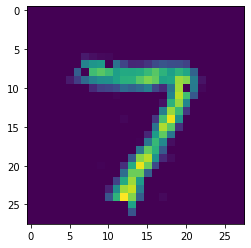

In [13]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
model.compile(optimizer=tf.optimizers.RMSprop(1e-3), 
              loss=tf.losses.mse)

# run training loop
model.fit(train_data, train_data, epochs=n_epochs)

# evaluate performance on test set
print("Test error:", model.evaluate(test_data, test_data))

# display example output
output = model.predict(test_data[[0]])
plt.figure()
plt.imshow(output[0].reshape((28, 28)));

Before running the same training in NengoDL, we'll change the Nengo model parameters to more closely match the TensorFlow network (we omitted these details in the original presentation to keep things simple).

In [14]:
# set initial neuron gains to 1 and biases to 0
for ens in auto_net.all_ensembles:
    ens.gain = nengo.dists.Choice([1])
    ens.bias = nengo.dists.Choice([0])

# disable synaptic filtering on all connections
for conn in auto_net.all_connections:
    conn.synapse = None

We also need to modify the data slightly.  As mentioned above, NengoDL simulations are essentially temporal, so data is described over time (indicating what the inputs/targets should be on each simulation timestep).  So instead of the data having shape `(batch_size, n)`, it will have shape `(batch_size, n_steps, n)`.  In this case we'll just be training for a single timestep, but we still need to add that extra axis with length 1.

In [15]:
train_data = train_data[:, None, :]
test_data = test_data[:, None, :]

Now we can run the NengoDL equivalent of the above TensorFlow training:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (30%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

| #                       Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Train on 60000 samples
Epoch 1/2


   50/60000 [..............................] - ETA: 0s - loss: 7022.9399 - probe_loss: 7022.9399

  800/60000 [..............................] - ETA: 3s - loss: 4760.6945 - probe_loss: 4760.6943

 1550/60000 [..............................] - ETA: 3s - loss: 4203.1201 - probe_loss: 4203.1201

 2350/60000 [>.............................] - ETA: 3s - loss: 3798.4954 - probe_loss: 3798.4954

 3150/60000 [>.............................] - ETA: 3s - loss: 3514.4182 - probe_loss: 3514.4182

 3900/60000 [>.............................] - ETA: 3s - loss: 3311.8621 - probe_loss: 3311.8618

 4650/60000 [=>............................] - ETA: 3s - loss: 3147.9509 - probe_loss: 3147.9507

 5400/60000 [=>............................] - ETA: 3s - loss: 3011.2521 - probe_loss: 3011.2520

 6200/60000 [==>...........................] - ETA: 3s - loss: 2886.4118 - probe_loss: 2886.4119

 6950/60000 [==>...........................] - ETA: 3s - loss: 2780.4773 - probe_loss: 2780.4778

 7750/60000 [==>...........................] - ETA: 3s - loss: 2688.0817 - probe_loss: 2688.0820

 8500/60000 [===>..........................] - ETA: 3s - loss: 2611.6833 - probe_loss: 2611.6833

 9300/60000 [===>..........................] - ETA: 3s - loss: 2541.7264 - probe_loss: 2541.7263

10100/60000 [====>.........................] - ETA: 3s - loss: 2475.5301 - probe_loss: 2475.5303

10850/60000 [====>.........................] - ETA: 3s - loss: 2418.6677 - probe_loss: 2418.6677

11650/60000 [====>.........................] - ETA: 3s - loss: 2363.5270 - probe_loss: 2363.5264

12450/60000 [=====>........................] - ETA: 3s - loss: 2314.6533 - probe_loss: 2314.6528

13250/60000 [=====>........................] - ETA: 3s - loss: 2268.3813 - probe_loss: 2268.3809

14050/60000 [======>.......................] - ETA: 3s - loss: 2225.9612 - probe_loss: 2225.9612

14800/60000 [======>.......................] - ETA: 3s - loss: 2187.9136 - probe_loss: 2187.9133

15550/60000 [======>.......................] - ETA: 2s - loss: 2154.1692 - probe_loss: 2154.1687

16300/60000 [=======>......................] - ETA: 2s - loss: 2123.4370 - probe_loss: 2123.4365

17000/60000 [=======>......................] - ETA: 2s - loss: 2095.9954 - probe_loss: 2095.9949

17800/60000 [=======>......................] - ETA: 2s - loss: 2065.3744 - probe_loss: 2065.3740

18600/60000 [========>.....................] - ETA: 2s - loss: 2035.4492 - probe_loss: 2035.4487

19350/60000 [========>.....................] - ETA: 2s - loss: 2008.7621 - probe_loss: 2008.7615

20150/60000 [=========>....................] - ETA: 2s - loss: 1982.5531 - probe_loss: 1982.5529

20950/60000 [=========>....................] - ETA: 2s - loss: 1958.4504 - probe_loss: 1958.4502

21700/60000 [=========>....................] - ETA: 2s - loss: 1937.1531 - probe_loss: 1937.1528

22450/60000 [==========>...................] - ETA: 2s - loss: 1916.9326 - probe_loss: 1916.9324

23250/60000 [==========>...................] - ETA: 2s - loss: 1896.1387 - probe_loss: 1896.1385

24050/60000 [===========>..................] - ETA: 2s - loss: 1875.8190 - probe_loss: 1875.8186

24850/60000 [===========>..................] - ETA: 2s - loss: 1855.6022 - probe_loss: 1855.6018

25600/60000 [===========>..................] - ETA: 2s - loss: 1837.8888 - probe_loss: 1837.8885

26400/60000 [============>.................] - ETA: 2s - loss: 1820.3316 - probe_loss: 1820.3315

27200/60000 [============>.................] - ETA: 2s - loss: 1803.6789 - probe_loss: 1803.6788

28000/60000 [=============>................] - ETA: 2s - loss: 1787.1817 - probe_loss: 1787.1816

28800/60000 [=============>................] - ETA: 2s - loss: 1771.9643 - probe_loss: 1771.9645

29600/60000 [=============>................] - ETA: 2s - loss: 1755.3047 - probe_loss: 1755.3051

30400/60000 [==============>...............] - ETA: 1s - loss: 1741.6428 - probe_loss: 1741.6427

31200/60000 [==============>...............] - ETA: 1s - loss: 1727.5519 - probe_loss: 1727.5522

31900/60000 [==============>...............] - ETA: 1s - loss: 1714.9152 - probe_loss: 1714.9155

32550/60000 [===============>..............] - ETA: 1s - loss: 1703.4374 - probe_loss: 1703.4376

33350/60000 [===============>..............] - ETA: 1s - loss: 1691.3202 - probe_loss: 1691.3203

34100/60000 [================>.............] - ETA: 1s - loss: 1680.1907 - probe_loss: 1680.1908

34900/60000 [================>.............] - ETA: 1s - loss: 1667.8392 - probe_loss: 1667.8397

35700/60000 [================>.............] - ETA: 1s - loss: 1656.3331 - probe_loss: 1656.3335

36500/60000 [=================>............] - ETA: 1s - loss: 1644.8853 - probe_loss: 1644.8857

37250/60000 [=================>............] - ETA: 1s - loss: 1635.0263 - probe_loss: 1635.0269

38000/60000 [==================>...........] - ETA: 1s - loss: 1625.5471 - probe_loss: 1625.5475

38800/60000 [==================>...........] - ETA: 1s - loss: 1615.2715 - probe_loss: 1615.2721

39600/60000 [==================>...........] - ETA: 1s - loss: 1604.8412 - probe_loss: 1604.8418

40200/60000 [===================>..........] - ETA: 1s - loss: 1597.7064 - probe_loss: 1597.7073

40950/60000 [===================>..........] - ETA: 1s - loss: 1588.8710 - probe_loss: 1588.8721

41750/60000 [===================>..........] - ETA: 1s - loss: 1579.2842 - probe_loss: 1579.2852

42550/60000 [====================>.........] - ETA: 1s - loss: 1569.9895 - probe_loss: 1569.9906

43350/60000 [====================>.........] - ETA: 1s - loss: 1561.5781 - probe_loss: 1561.5791

44050/60000 [=====================>........] - ETA: 1s - loss: 1553.9723 - probe_loss: 1553.9735

44750/60000 [=====================>........] - ETA: 1s - loss: 1546.4304 - probe_loss: 1546.4315

45550/60000 [=====================>........] - ETA: 0s - loss: 1538.4313 - probe_loss: 1538.4323

46350/60000 [======================>.......] - ETA: 0s - loss: 1530.1771 - probe_loss: 1530.1780

47100/60000 [======================>.......] - ETA: 0s - loss: 1523.0515 - probe_loss: 1523.0520

47900/60000 [======================>.......] - ETA: 0s - loss: 1515.6350 - probe_loss: 1515.6355

48700/60000 [=======================>......] - ETA: 0s - loss: 1508.2938 - probe_loss: 1508.2942

49450/60000 [=======================>......] - ETA: 0s - loss: 1501.1761 - probe_loss: 1501.1765

50250/60000 [========================>.....] - ETA: 0s - loss: 1494.1754 - probe_loss: 1494.1761

51050/60000 [========================>.....] - ETA: 0s - loss: 1486.9574 - probe_loss: 1486.9583

51800/60000 [========================>.....] - ETA: 0s - loss: 1481.0093 - probe_loss: 1481.0100

52600/60000 [=========================>....] - ETA: 0s - loss: 1474.9111 - probe_loss: 1474.9120

53350/60000 [=========================>....] - ETA: 0s - loss: 1469.5332 - probe_loss: 1469.5339

54100/60000 [==========================>...] - ETA: 0s - loss: 1463.8833 - probe_loss: 1463.8840

54900/60000 [==========================>...] - ETA: 0s - loss: 1457.2407 - probe_loss: 1457.2417

55700/60000 [==========================>...] - ETA: 0s - loss: 1451.1223 - probe_loss: 1451.1234

56400/60000 [===========================>..] - ETA: 0s - loss: 1446.0574 - probe_loss: 1446.0586

57200/60000 [===========================>..] - ETA: 0s - loss: 1440.5508 - probe_loss: 1440.5520

58000/60000 [============================>.] - ETA: 0s - loss: 1435.4644 - probe_loss: 1435.4653

58800/60000 [============================>.] - ETA: 0s - loss: 1430.1091 - probe_loss: 1430.1097

59550/60000 [============================>.] - ETA: 0s - loss: 1424.6565 - probe_loss: 1424.6573

60000/60000 [==============================] - 4s 67us/sample - loss: 1422.0507 - probe_loss: 1422.0515


Epoch 2/2
   50/60000 [..............................] - ETA: 0s - loss: 1095.6051 - probe_loss: 1095.6051

  800/60000 [..............................] - ETA: 3s - loss: 1038.7568 - probe_loss: 1038.7568

 1550/60000 [..............................] - ETA: 3s - loss: 1041.8730 - probe_loss: 1041.8730

 2250/60000 [>.............................] - ETA: 3s - loss: 1027.3723 - probe_loss: 1027.3722

 3000/60000 [>.............................] - ETA: 3s - loss: 1027.8487 - probe_loss: 1027.8488

 3800/60000 [>.............................] - ETA: 3s - loss: 1024.8071 - probe_loss: 1024.8070

 4600/60000 [=>............................] - ETA: 3s - loss: 1030.6205 - probe_loss: 1030.6204

 5350/60000 [=>............................] - ETA: 3s - loss: 1026.2207 - probe_loss: 1026.2206

 6150/60000 [==>...........................] - ETA: 3s - loss: 1021.1148 - probe_loss: 1021.1147

 6900/60000 [==>...........................] - ETA: 3s - loss: 1021.2456 - probe_loss: 1021.2456

 7650/60000 [==>...........................] - ETA: 3s - loss: 1018.8915 - probe_loss: 1018.8914

 8450/60000 [===>..........................] - ETA: 3s - loss: 1017.0463 - probe_loss: 1017.0461

 9250/60000 [===>..........................] - ETA: 3s - loss: 1019.5105 - probe_loss: 1019.5104

10050/60000 [====>.........................] - ETA: 3s - loss: 1014.6456 - probe_loss: 1014.6455

10800/60000 [====>.........................] - ETA: 3s - loss: 1014.0096 - probe_loss: 1014.0095

11600/60000 [====>.........................] - ETA: 3s - loss: 1013.7715 - probe_loss: 1013.7714

12300/60000 [=====>........................] - ETA: 3s - loss: 1013.2107 - probe_loss: 1013.2105

13050/60000 [=====>........................] - ETA: 3s - loss: 1012.4620 - probe_loss: 1012.4618

13850/60000 [=====>........................] - ETA: 3s - loss: 1011.6648 - probe_loss: 1011.6645

14600/60000 [======>.......................] - ETA: 3s - loss: 1009.7366 - probe_loss: 1009.7364

15400/60000 [======>.......................] - ETA: 2s - loss: 1007.4873 - probe_loss: 1007.4870

16200/60000 [=======>......................] - ETA: 2s - loss: 1007.2393 - probe_loss: 1007.2391

17000/60000 [=======>......................] - ETA: 2s - loss: 1005.8059 - probe_loss: 1005.8058

17800/60000 [=======>......................] - ETA: 2s - loss: 1005.0541 - probe_loss: 1005.0538

18600/60000 [========>.....................] - ETA: 2s - loss: 1003.8042 - probe_loss: 1003.8038

19400/60000 [========>.....................] - ETA: 2s - loss: 1001.1447 - probe_loss: 1001.1442

20150/60000 [=========>....................] - ETA: 2s - loss: 999.7033 - probe_loss: 999.7029  

20800/60000 [=========>....................] - ETA: 2s - loss: 998.5988 - probe_loss: 998.5985

21600/60000 [=========>....................] - ETA: 2s - loss: 997.3327 - probe_loss: 997.3325

22400/60000 [==========>...................] - ETA: 2s - loss: 996.0579 - probe_loss: 996.0576

23200/60000 [==========>...................] - ETA: 2s - loss: 994.6939 - probe_loss: 994.6935

24000/60000 [===========>..................] - ETA: 2s - loss: 992.8164 - probe_loss: 992.8163

24800/60000 [===========>..................] - ETA: 2s - loss: 992.8501 - probe_loss: 992.8499

25550/60000 [===========>..................] - ETA: 2s - loss: 990.9003 - probe_loss: 990.9001

26350/60000 [============>.................] - ETA: 2s - loss: 991.7862 - probe_loss: 991.7860

27150/60000 [============>.................] - ETA: 2s - loss: 989.9700 - probe_loss: 989.9698

27950/60000 [============>.................] - ETA: 2s - loss: 989.4334 - probe_loss: 989.4333

28750/60000 [=============>................] - ETA: 2s - loss: 988.1658 - probe_loss: 988.1658

29500/60000 [=============>................] - ETA: 2s - loss: 987.9924 - probe_loss: 987.9922

30250/60000 [==============>...............] - ETA: 1s - loss: 987.4778 - probe_loss: 987.4777

31050/60000 [==============>...............] - ETA: 1s - loss: 986.7167 - probe_loss: 986.7167

31850/60000 [==============>...............] - ETA: 1s - loss: 986.8597 - probe_loss: 986.8600

32650/60000 [===============>..............] - ETA: 1s - loss: 985.9607 - probe_loss: 985.9609

33450/60000 [===============>..............] - ETA: 1s - loss: 983.8940 - probe_loss: 983.8942

34250/60000 [================>.............] - ETA: 1s - loss: 983.1329 - probe_loss: 983.1332

35050/60000 [================>.............] - ETA: 1s - loss: 983.5492 - probe_loss: 983.5495

35850/60000 [================>.............] - ETA: 1s - loss: 983.3410 - probe_loss: 983.3412

36650/60000 [=================>............] - ETA: 1s - loss: 982.7016 - probe_loss: 982.7018

37400/60000 [=================>............] - ETA: 1s - loss: 981.6589 - probe_loss: 981.6592

38200/60000 [==================>...........] - ETA: 1s - loss: 981.1692 - probe_loss: 981.1693

39000/60000 [==================>...........] - ETA: 1s - loss: 980.6628 - probe_loss: 980.6629

39800/60000 [==================>...........] - ETA: 1s - loss: 979.9646 - probe_loss: 979.9645

40550/60000 [===================>..........] - ETA: 1s - loss: 979.1366 - probe_loss: 979.1367

41350/60000 [===================>..........] - ETA: 1s - loss: 978.9878 - probe_loss: 978.9877

42150/60000 [====================>.........] - ETA: 1s - loss: 978.2242 - probe_loss: 978.2241

42950/60000 [====================>.........] - ETA: 1s - loss: 977.3826 - probe_loss: 977.3825

43750/60000 [====================>.........] - ETA: 1s - loss: 976.9075 - probe_loss: 976.9073

44550/60000 [=====================>........] - ETA: 1s - loss: 976.3185 - probe_loss: 976.3182

45300/60000 [=====================>........] - ETA: 0s - loss: 975.3180 - probe_loss: 975.3177

46050/60000 [======================>.......] - ETA: 0s - loss: 974.9695 - probe_loss: 974.9692

46800/60000 [======================>.......] - ETA: 0s - loss: 975.0341 - probe_loss: 975.0339

47600/60000 [======================>.......] - ETA: 0s - loss: 974.0996 - probe_loss: 974.0995

48400/60000 [=======================>......] - ETA: 0s - loss: 973.8188 - probe_loss: 973.8187

49100/60000 [=======================>......] - ETA: 0s - loss: 973.3007 - probe_loss: 973.3006

49600/60000 [=======================>......] - ETA: 0s - loss: 972.4548 - probe_loss: 972.4547

50350/60000 [========================>.....] - ETA: 0s - loss: 972.1948 - probe_loss: 972.1946

51150/60000 [========================>.....] - ETA: 0s - loss: 972.1993 - probe_loss: 972.1992

51900/60000 [========================>.....] - ETA: 0s - loss: 971.7901 - probe_loss: 971.7900

52650/60000 [=========================>....] - ETA: 0s - loss: 971.2648 - probe_loss: 971.2648

53450/60000 [=========================>....] - ETA: 0s - loss: 970.8702 - probe_loss: 970.8701

54200/60000 [==========================>...] - ETA: 0s - loss: 970.8920 - probe_loss: 970.8920

55000/60000 [==========================>...] - ETA: 0s - loss: 970.1254 - probe_loss: 970.1252

55700/60000 [==========================>...] - ETA: 0s - loss: 969.5794 - probe_loss: 969.5791

56500/60000 [===========================>..] - ETA: 0s - loss: 969.2399 - probe_loss: 969.2396

57300/60000 [===========================>..] - ETA: 0s - loss: 968.6207 - probe_loss: 968.6203

58100/60000 [============================>.] - ETA: 0s - loss: 967.9026 - probe_loss: 967.9022

58850/60000 [============================>.] - ETA: 0s - loss: 967.9313 - probe_loss: 967.9310

59600/60000 [============================>.] - ETA: 0s - loss: 967.3361 - probe_loss: 967.3357

60000/60000 [==============================] - 4s 67us/sample - loss: 967.0669 - probe_loss: 967.0663


Test error: OrderedDict([('loss', 912.4536709594727), ('probe_loss', 912.4536)])


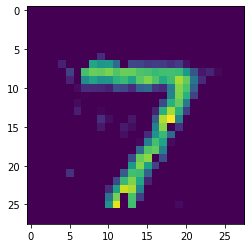

In [16]:
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), 
                loss=tf.losses.mse)

    # run training loop
    sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    print("Test error:", sim.evaluate(test_data, test_data))

    # display example output
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.imshow(output[p_c][0].reshape((28, 28)));

More details on using `sim.fit` can be found in [the user guide](https://www.nengo.ai/nengo-dl/simulator.html).

## NEF parameter optimization

NengoDL also provides access to a different optimization method, the Neural Engineering Framework (NEF).  This uses linear least-squares optimization to solve for optimal connection weights analytically, rather than using an iterative gradient-descent based algorithm.  The advantage of the NEF is that it is very fast and general (for example, it does not require the network to be differentiable).  The disadvantage is that it optimizes each set of connection weights individually (i.e., it cannot jointly optimize across multiple layers).

The NEF optimization is accessed by setting the `function` argument on a `nengo.Connection`.  This specifies the function that we would like those connection weights to approximate.  In addition, in previous examples you may have noticed that we were forming Connections using `ensemble.neurons` (rather than `ensemble`).  Using `ensemble.neurons` specifies that we want to form a direct connection between ensemble neurons, without applying the NEF optimization.  So when we want to use the `function` argument, the `Connection` source object should be an `ensemble`, not `ensemble.neurons`.  For example, we could use the NEF to create a network to approximate the function $sin(x^2)$:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

| #                       Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|######        Constructing graph: build stage (10%)             | ETA: 0:00:00

|##############Constructing graph: build stage (50%)             | ETA: 0:00:00

|##############Constructing graph: build stage (90%)######       | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|   #                     Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

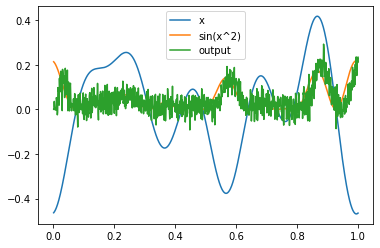

In [17]:
with nengo.Network(seed=0) as net:    
    # input node outputting a random signal for x
    inpt = nengo.Node(nengo.processes.WhiteSignal(1, 5, rms=0.3))
    
    # first ensemble, will compute x^2
    ens0 = nengo.Ensemble(50, 1)
    
    # second ensemble, will compute sin(x^2)
    ens1 = nengo.Ensemble(50, 1)
    
    # output node
    outpt = nengo.Node(size_in=1)
    
    # connect input to first ensemble
    nengo.Connection(inpt, ens0)
    
    # connect first to second ensemble, solve for weights
    # to approximate the square function
    nengo.Connection(ens0, ens1, function=np.square)
    
    # connect second ensemble to output, solve for weights
    # to approximate the sin function
    nengo.Connection(ens1, outpt, function=np.sin)
    
    # add a probe on the input and output
    inpt_p = nengo.Probe(inpt)
    outpt_p = nengo.Probe(outpt)
    
with nengo_dl.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)
    
plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p]**2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend();

The NEF optimization can be used in combination with the deep learning optimization methods.  For example, we could optimize some parameters with the NEF and others with `sim.fit` (see [this example](https://www.nengo.ai/nengo-dl/examples/from-nengo.html)).  Or we could initialize each set of connection weights individually with the NEF, and then further refine them with end-to-end training via `sim.fit`.  As always, the overall theme is that NengoDL allows us to use whichever method is most appropriate for a particular goal.

See [this example](https://www.nengo.ai/nengo/examples/advanced/nef_summary.html) for a deeper introduction to the principles of the NEF.

## Running on neuromorphic hardware

Neuromorphic hardware is specialized compute hardware designed to simulate neuromorphic networks quickly/efficiently.  However, often it is difficult to program this custom hardware, and it requires writing custom code for each neuromorphic platform.  One of the primary design goals of Nengo is to alleviate these challenges, by providing a single API that can be used to build networks across many different neuromorphic platforms.  

The idea is that the front-end network construction code is the same (`Networks`, `Nodes`, `Ensembles`, `Connections`, and `Probes`), and then each platform has its own `Simulator` class (the back-end) that compiles and executes that network definition for some compute platform.  This provides a consistent interface so that we only need to write code once and can then run that network on novel hardware platforms with no additional effort.  For example, we could take the network from above and simulate it on different hardware platforms:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

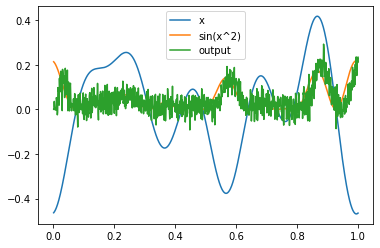

In [18]:
# run on a standard CPU
with nengo.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)
    
# run on Loihi neuromorphic hardware 
# (requires https://www.nengo.ai/nengo-loihi/)
# with nengo_loihi.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

# run on SpiNNaker neuromorphic hardware 
# (requires https://github.com/project-rig/nengo_spinnaker)
# with nengo_spinnaker.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)
    
# run on any OpenCL-compatible hardware
# (requires https://github.com/nengo/nengo-ocl)
# with nengo_ocl.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p]**2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend();

We have commented out the different backends above because they require extra installation steps, but if you are running this example yourself you can install any of those backends (or more) and uncomment that code to see the same network running on that new hardware platform.  Note that we can think of NengoDL as a TensorFlow back-end (among other things); it takes a standard Nengo network, and simulates it using TensorFlow.

We can take advantage of this cross-platform compatibility to effectively incorporate NengoDL's deep learning functionality into any other Nengo back-end.  We build our Network, optimize it in NengoDL, save the optimized model parameters back into the Network definition, and then simulate that optimized Network in a different back-end.  See [this example in nengo-loihi](https://www.nengo.ai/nengo-loihi/examples/mnist_convnet.html), where a spiking network is optimized in NengoDL and then deployed on Loihi.

## Conclusion

In this tutorial we have demonstrated how to translate TensorFlow concepts into NengoDL, including network construction, execution, and optimization.  We have also discussed how to use TensorNodes to combine TensorFlow and Nengo code, and introduced some of the unique features of Nengo (such as NEF optimization and neuromorphic cross-platform execution).  However, there is much more functionality in NengoDL than we are able to introduce here; check out the [user guide](https://www.nengo.ai/nengo-dl/user-guide.html) or [other examples](https://www.nengo.ai/nengo-dl/examples.html) for more information.  If you would like more information on how NengoDL is implemented under the hood using TensorFlow, check out the [white paper](https://arxiv.org/abs/1805.11144).